In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skmatter.feature_selection import CUR, FPS

current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")
data_paths = {
    "energies": os.path.join(current_dir, "data", "energies_10000.npy"),
    "2-body": os.path.join(current_dir, "data", "features_2b_10000.npy"),
    "3-body": os.path.join(current_dir, "data", "features_3b_10000.npy"),
    "4-body": os.path.join(current_dir, "data", "features_4b_10000.npy"),
}

def load_data_standardized(feature_choice):
    """
    Dynamically load data based on the feature choice.
    Options:
    - "2-body": Use 2-body features only
    - "3-body": Use 3-body features only
    - "4-body": Use 4-body features only
    - "2+3-body": Combine 2-body and 3-body features
    - "3+4-body": Combine 3-body and 4-body features
    - "2+3+4-body": Combine all features
    """
    energies = np.load(data_paths["energies"])

    if feature_choice == "2-body":
        features = np.load(data_paths["2-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "3-body":
        features = np.load(data_paths["3-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "4-body":
        features = np.load(data_paths["4-body"])
        features = (features - features.mean())/features.std()
    elif feature_choice == "2+3-body":
        features_2 = np.load(data_paths["2-body"])
        features_2 =(features_2 - features_2.mean())/features_2.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features = np.hstack((features_2, features_3))
    elif feature_choice == "4+3-body":
        features_4 = np.load(data_paths["4-body"])
        features_4 = (features_4 - features_4.mean())/features_4.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features = np.hstack((features_4, features_3))
    elif feature_choice == "2+3+4-body":
        features_2 = np.load(data_paths["2-body"])
        features_2 = (features_2 - features_2.mean())/features_2.std()
        features_3 = np.load(data_paths["3-body"])
        features_3 = (features_3 - features_3.mean())/features_3.std()
        features_4 = np.load(data_paths["4-body"])
        features_4 = (features_4 - features_4.mean())/features_4.std()
        features = np.hstack((features_2, features_3, features_4))
    else:
        raise ValueError("Invalid feature choice!")

    energies = (energies - energies.mean())/energies.std()

    return features, energies

Current working directory: c:\Users\valbi\Desktop\Ma3\ML\Project2


In [2]:
X,y = load_data_standardized("2-body")

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

def rbf_kernel(X, Y, sigma=1.0):
    pairwise_sq_dists = np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(Y**2, axis=1)[np.newaxis, :] - 2 * np.dot(X, Y.T)
    return np.exp(-pairwise_sq_dists / (2 * sigma**2))

def polynomial_kernel(X, Y, p=2):
    return (np.dot(X, Y.T))**p

class KernelRidgeRegression:
    def __init__(self, kernel, alpha=1.0, **kernel_params):
        self.kernel = kernel
        self.alpha = alpha
        self.kernel_params = kernel_params

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        K = self.kernel(X, X, **self.kernel_params)
        n = K.shape[0]
        self.alpha_vec = np.linalg.solve(K + self.alpha * np.eye(n), y)

    def predict(self, X):
        K_test = self.kernel(X, self.X_train, **self.kernel_params)
        return np.dot(K_test, self.alpha_vec)

def plot_learning_curve_krr_with_all_errors(
    X, y, kernel, kernel_params, alpha=1.0, n_splits=5, train_sizes=np.logspace(np.log10(0.01), np.log10(1), 8)
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_train_errors = []
    all_test_errors = []

    subset_sizes = []

    for train_size in train_sizes:
        fold_train_errors = []
        fold_test_errors = []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            subset_size = int(train_size * len(X_train))
            subset_size = min(subset_size, len(X_train))  

            if subset_size not in subset_sizes:
                subset_sizes.append(subset_size)

            X_train_subset = X_train[:subset_size]  
            y_train_subset = y_train[:subset_size]

            model = KernelRidgeRegression(kernel=kernel, alpha=alpha, **kernel_params)
            model.fit(X_train_subset, y_train_subset)

            y_train_pred = model.predict(X_train_subset)
            y_test_pred = model.predict(X_test)

            fold_train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
            fold_test_errors.append(mean_squared_error(y_test, y_test_pred))

        all_train_errors.append(fold_train_errors)
        all_test_errors.append(fold_test_errors)

    all_train_errors = np.array(all_train_errors)
    all_test_errors = np.array(all_test_errors)

    np.save("train_errors_krr_P2.npy", all_train_errors.T)
    np.save("test_errors_krr_P2.npy", all_test_errors.T)

    train_means = np.mean(all_train_errors, axis=1)
    test_means = np.mean(all_test_errors, axis=1)
    train_stds = np.std(all_train_errors, axis=1)
    test_stds = np.std(all_test_errors, axis=1)

    subset_sizes = np.array(subset_sizes[:len(train_means)])
    
    plt.figure(figsize=(10, 6))
    plt.errorbar(
        subset_sizes, train_means, yerr=train_stds, fmt='o-', label="Training Error", color="r", capsize=3
    )
    plt.errorbar(
        subset_sizes, test_means, yerr=test_stds, fmt='o-', label="Testing Error", color="g", capsize=3
    )
    plt.fill_between(
        subset_sizes,
        train_means - train_stds,
        train_means + train_stds,
        color="r", alpha=0.2, label="Train Error Std Dev"
    )
    plt.fill_between(
        subset_sizes,
        test_means - test_stds,
        test_means + test_stds,
        color="g", alpha=0.2, label="Test Error Std Dev"
    )
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for Kernel Ridge Regression (Subset Size)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 6))
    for idx, fold_train_errors in enumerate(all_train_errors.T):  # Transpose for fold-wise errors
        plt.plot(subset_sizes, fold_train_errors, label=f"Fold {idx + 1} - Train", color="r", alpha=0.6)
    for idx, fold_test_errors in enumerate(all_test_errors.T):  # Transpose for fold-wise errors
        plt.plot(subset_sizes, fold_test_errors, label=f"Fold {idx + 1} - Test", color="g", alpha=0.6)

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve for Kernel Ridge Regression (Subset Size) - All Folds")
    plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
    plt.grid()
    plt.show()


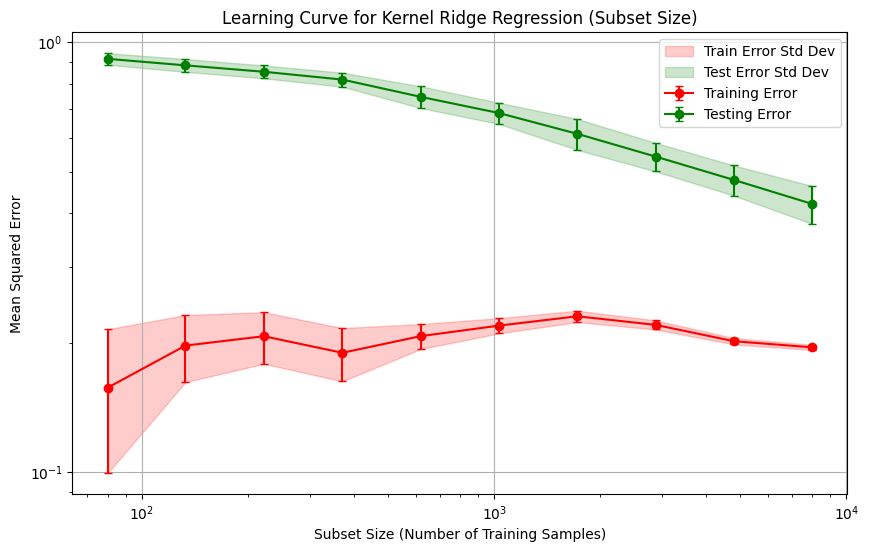

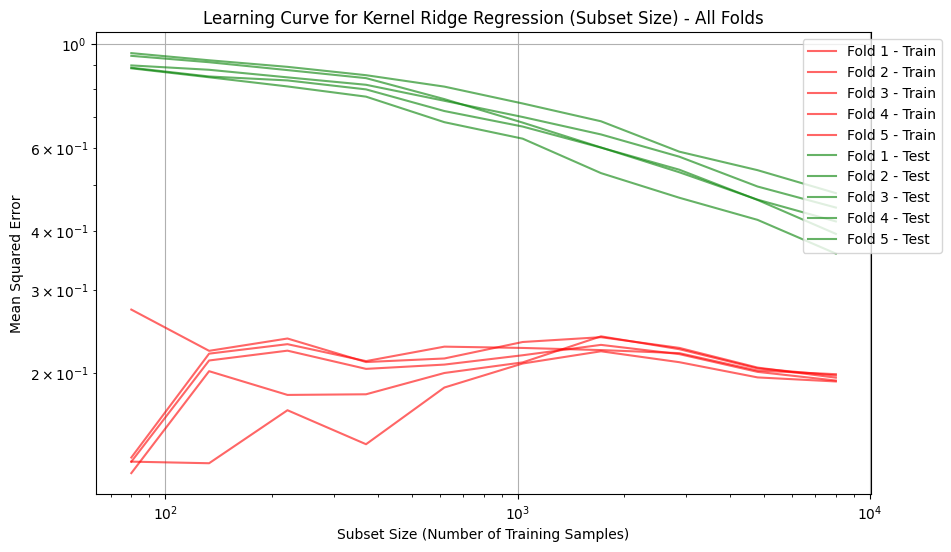

In [ ]:

plot_learning_curve_krr_with_all_errors(
    X, y,
    kernel=rbf_kernel,
    kernel_params={'sigma': 1.0},
    alpha=1,
    train_sizes=np.logspace(np.log10(0.01), np.log10(1), 10)
    sampling
)



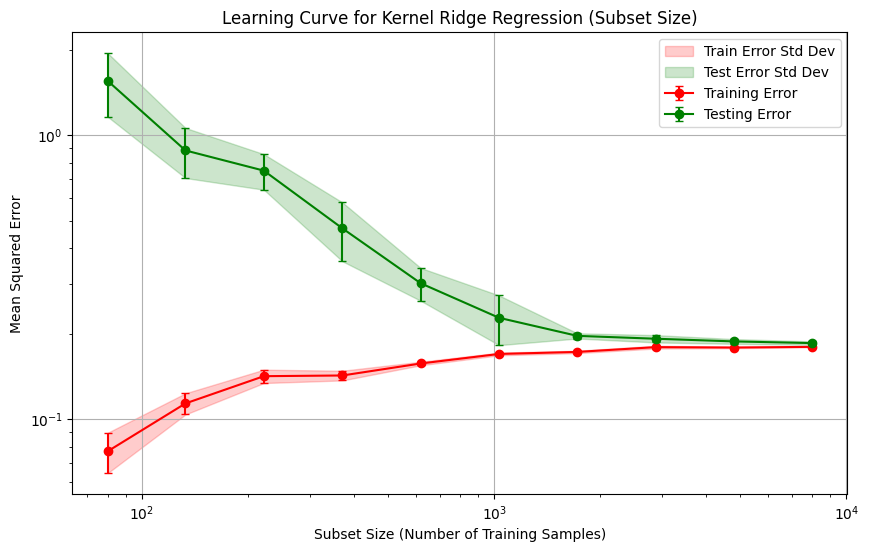

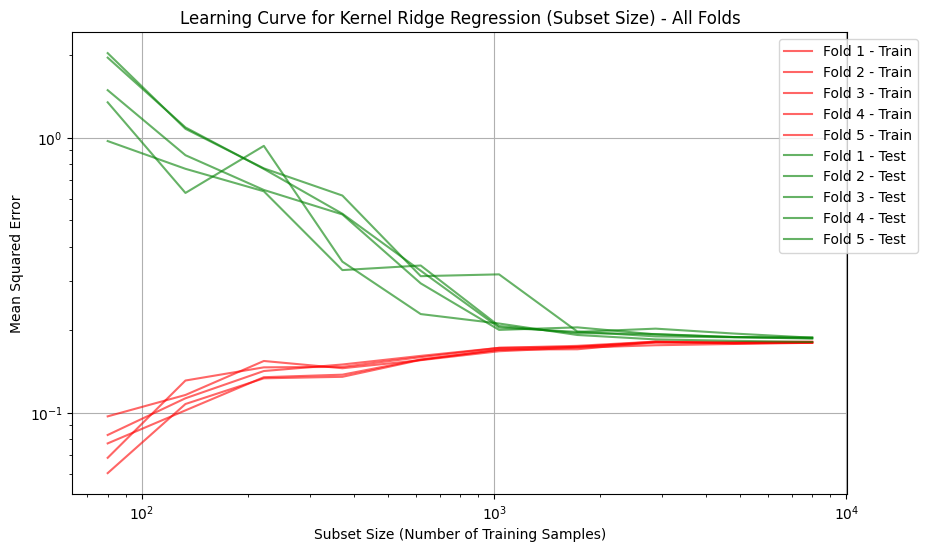

In [126]:
plot_learning_curve_krr_with_all_errors(
    X, y,
    kernel=polynomial_kernel,
    kernel_params={'p': 2},
    alpha=1,
    train_sizes=np.logspace(np.log10(0.01), np.log(1), 10)
)

In [4]:
def plot_learning_curve_krr_with_hyperparams(
    X, y, kernel, kernel_param_name, kernel_param_values, alpha=1.0, n_splits=5, train_size=1.0
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    all_train_errors = {}
    all_test_errors = {}

    for param_value in kernel_param_values:
        fold_train_errors = []
        fold_test_errors = []

        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]

            subset_size = int(train_size * len(X_train))
            X_train_subset = X_train[:subset_size]
            y_train_subset = y_train[:subset_size]

            kernel_params = {kernel_param_name: param_value}
            model = KernelRidgeRegression(kernel=kernel, alpha=alpha, **kernel_params)
            model.fit(X_train_subset, y_train_subset)

            y_train_pred = model.predict(X_train_subset)
            y_test_pred = model.predict(X_test)

            fold_train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
            fold_test_errors.append(mean_squared_error(y_test, y_test_pred))

        all_train_errors[param_value] = fold_train_errors
        all_test_errors[param_value] = fold_test_errors

    np.save(f'all_train_errors_krr_{kernel_param_name}.npy', np.array(all_train_errors))
    np.save(f'all_test_errors_krr_{kernel_param_name}.npy', np.array(all_test_errors))
    
    train_means = np.mean(all_train_errors, axis=1)
    test_means = np.mean(all_test_errors, axis=1)
    train_stds = np.std(all_train_errors, axis=1)
    test_stds = np.std(all_test_errors, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(kernel_param_values, train_means, 'o-', label="Training Error", color="r")
    plt.plot(kernel_param_values, test_means, 'o-', label="Testing Error", color="g")

    plt.fill_between(
        kernel_param_values, 
        np.array(train_means) - np.array(train_stds), 
        np.array(train_means) + np.array(train_stds), 
        color="r", alpha=0.2, label="Train Error Std Dev"
    )
    plt.fill_between(
        kernel_param_values, 
        np.array(test_means) - np.array(test_stds), 
        np.array(test_means) + np.array(test_stds), 
        color="g", alpha=0.2, label="Test Error Std Dev"
    )

    plt.xscale("log" if kernel_param_name == "sigma" else "linear")
    plt.yscale("log")
    plt.xlabel(f"{kernel_param_name} (Hyperparameter)")
    plt.ylabel("Mean Squared Error")
    plt.title(f"Learning Curve for Kernel Ridge Regression ({kernel_param_name})")
    plt.legend()
    plt.grid()
    plt.show()


In [5]:
plot_learning_curve_krr_with_hyperparams(
    X, y, kernel=rbf_kernel, kernel_param_name="sigma", kernel_param_values=[0.1, 0.5, 1.0, 5.0, 10.0], alpha=1
)

AxisError: axis 1 is out of bounds for array of dimension 0

In [ ]:
plot_learning_curve_krr_with_hyperparams(
    X, y, kernel=polynomial_kernel, kernel_param_name="p", kernel_param_values=[1, 2, 4], alpha=1
)

NameError: name 'polynomial_kernel' is not defined

C:\Users\valbi\AppData\Local\Temp\ipykernel_20228\2569620923.py:30: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, means, yerr=stds, fmt='o-', label=f"Error: {error_file}", capsize=3, linestyle=style, color=color)
C:\Users\valbi\AppData\Local\Temp\ipykernel_20228\2569620923.py:49: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x_values, means, yerr=stds, fmt='o-', label=f"Training: {training_file}", capsize=3, linestyle=style, color=color)


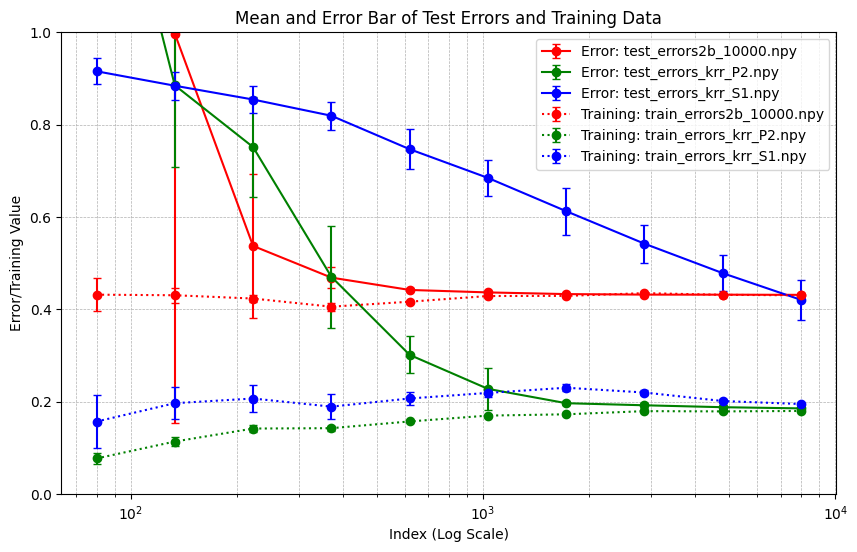

In [ ]:
comparison_dir = r"C:\Users\valbi\Desktop\Ma3\ML\Project2\data\comparisonMethod2b"

error_files = [f for f in os.listdir(comparison_dir) if f.startswith("test_error")]
training_files = [f for f in os.listdir(comparison_dir) if f.startswith("train_error")]

line_styles = ['-','-','-',':',':',':']
colors = ['r', 'g', 'b']

plt.figure(figsize=(10, 6))
for idx, error_file in enumerate(error_files):
    error_data = np.load(os.path.join(comparison_dir, error_file), allow_pickle=True)
    
    means = np.mean(error_data, axis=0)
    stds = np.std(error_data, axis=0)

    x_values = np.logspace(np.log10(80), np.log10(8000), num=len(means))
    
    style = line_styles[idx % len(line_styles)]
    color = colors[idx % len(colors)]
    
    plt.errorbar(x_values, means, yerr=stds, fmt='o-', label=f"Error: {error_file}", capsize=3, linestyle=style, color=color)

for idx, training_file in enumerate(training_files):

    training_data = np.load(os.path.join(comparison_dir, training_file), allow_pickle=True)
    
    means = np.mean(training_data, axis=0)
    stds = np.std(training_data, axis=0)
    
    x_values = np.logspace(np.log10(80), np.log10(8000), num=len(means))
    
    style = line_styles[(len(error_files) + idx) % len(line_styles)]
    color = colors[(len(error_files) + idx) % len(colors)]

    plt.errorbar(x_values, means, yerr=stds, fmt='o-', label=f"Training: {training_file}", capsize=3, linestyle=style, color=color)

plt.xscale("log")
plt.xlabel("Index (Log Scale)")
plt.ylabel("Error/Training Value")
plt.ylim(0, 1)
plt.title("Mean and Error Bar of Test Errors and Training Data")
plt.legend()
plt.grid(True, which="both", linestyle="--", linewidth=0.5)  # Add grid for both major and minor ticks
plt.show()


In [ ]:
comparison_dir = r"C:\Users\valbi\Desktop\Ma3\ML\Project2\data\comparisonMethod2b"

error_files = [f for f in os.listdir(comparison_dir) if f.startswith("test_error")]

if error_files:

    first_error_file = error_files[1]
    first_error_file_path = os.path.join(comparison_dir, first_error_file)
    first_error_data = np.load(first_error_file_path)

    print(f"Path to the first error file: {first_error_file_path}")
    print(f"First 10 elements of '{first_error_file}':")
    print(first_error_data[:10])
else:
    print("No files starting with 'test_error' found in the directory.")


Path to the first error file: C:\Users\valbi\Desktop\Ma3\ML\Project2\data\comparisonMethod2b\test_errors_krr_P2.npy
First 10 elements of 'test_errors_krr_P2.npy':
[[1.95109566 1.48601292 0.97072533 1.34240388 2.02640356]
 [1.08830622 0.86229104 0.76957166 0.62884711 1.0754096 ]
 [0.76877731 0.64475171 0.63768047 0.93240655 0.77249542]
 [0.52833325 0.52532292 0.32968439 0.35381273 0.61522868]
 [0.32794229 0.29503704 0.34258856 0.22817701 0.31334265]
 [0.20379217 0.19988148 0.20650427 0.21081786 0.31812848]
 [0.19654669 0.20416771 0.19460925 0.19152555 0.19712424]
 [0.20197626 0.19247046 0.19305379 0.18459525 0.18929986]
 [0.19386433 0.18819811 0.18830068 0.18240661 0.18791556]
 [0.18721785 0.18579551 0.18653315 0.18060721 0.1877962 ]]


In [18]:
def plot_learning_curve_krr_with_samplers(
    X, y, kernel, kernel_params, alpha=1.0, n_splits=5, train_sizes=np.logspace(np.log10(1), np.log10(1), 1),
    sampling_methods=["random", "CUR", "FPS"]
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    results = {method: {"train_errors": [], "test_errors": []} for method in sampling_methods}
    subset_sizes = []

    for train_size in train_sizes:
        for method in sampling_methods:
            fold_train_errors = []
            fold_test_errors = []

            for train_idx, test_idx in kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                y_train, y_test = y[train_idx], y[test_idx]

                subset_size = int(train_size * len(X_train))
                subset_size = min(subset_size, len(X_train))  
                if subset_size not in subset_sizes:
                    subset_sizes.append(subset_size)

                if method == "random":
                    indices = np.random.choice(len(X_train), subset_size, replace=False)
                elif method == "CUR":
                    sampler = CUR(n_to_select=subset_size)
                    sampler.fit(X_train.T)
                    indices = sampler.get_support(indices=True)
                elif method == "FPS":
                    sampler = FPS(n_to_select=subset_size)
                    sampler.fit(X_train.T)
                    indices = sampler.get_support(indices=True)

                X_train_subset = X_train[indices]
                y_train_subset = y_train[indices]

                model = KernelRidgeRegression(kernel=kernel, alpha=alpha, **kernel_params)
                model.fit(X_train_subset, y_train_subset)

                y_train_pred = model.predict(X_train_subset)
                y_test_pred = model.predict(X_test)

                fold_train_errors.append(mean_squared_error(y_train_subset, y_train_pred))
                fold_test_errors.append(mean_squared_error(y_test, y_test_pred))

            results[method]["train_errors"].append(fold_train_errors)
            results[method]["test_errors"].append(fold_test_errors)

    for method in sampling_methods:
        np.save(f"train_errors_krr_{method}.npy", np.array(results[method]["train_errors"]).T)
        np.save(f"test_errors_krr_{method}.npy", np.array(results[method]["test_errors"]).T)

    plt.figure(figsize=(12, 8))
    colors = {"random": "b", "CUR": "g", "FPS": "r"}

    for method in sampling_methods:
        all_train_errors = np.array(results[method]["train_errors"])
        all_test_errors = np.array(results[method]["test_errors"])

        train_means = np.mean(all_train_errors, axis=1)
        test_means = np.mean(all_test_errors, axis=1)
        train_stds = np.std(all_train_errors, axis=1)
        test_stds = np.std(all_test_errors, axis=1)

        plt.errorbar(
            subset_sizes, train_means, yerr=train_stds, fmt='o--', color=colors[method], label=f"{method} Train", capsize=3
        )
        plt.errorbar(
            subset_sizes, test_means, yerr=test_stds, fmt='o-', color=colors[method], label=f"{method} Test", capsize=3
        )

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Subset Size (Number of Training Samples)")
    plt.ylabel("Mean Squared Error")
    plt.title("Learning Curve Comparison with Different Sampling Methods")
    plt.legend()
    plt.grid()
    plt.show()


c:\Users\valbi\ML_env\lib\site-packages\skmatter\utils\_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.", stacklevel=1)
c:\Users\valbi\ML_env\lib\site-packages\skmatter\utils\_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.", stacklevel=1)
c:\Users\valbi\ML_env\lib\site-packages\skmatter\utils\_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.", stacklevel=1)
c:\Users\valbi\ML_env\lib\site-packages\skmatter\utils\_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.", stacklevel=1)
c:\Users\valbi\ML_env\lib\site-packages\skmatter\utils\_orthogonalizers.py:57: UserWarning: Column vector contains only zeros.
  warnings.warn("Column vector contains only zeros.", stacklevel=1)


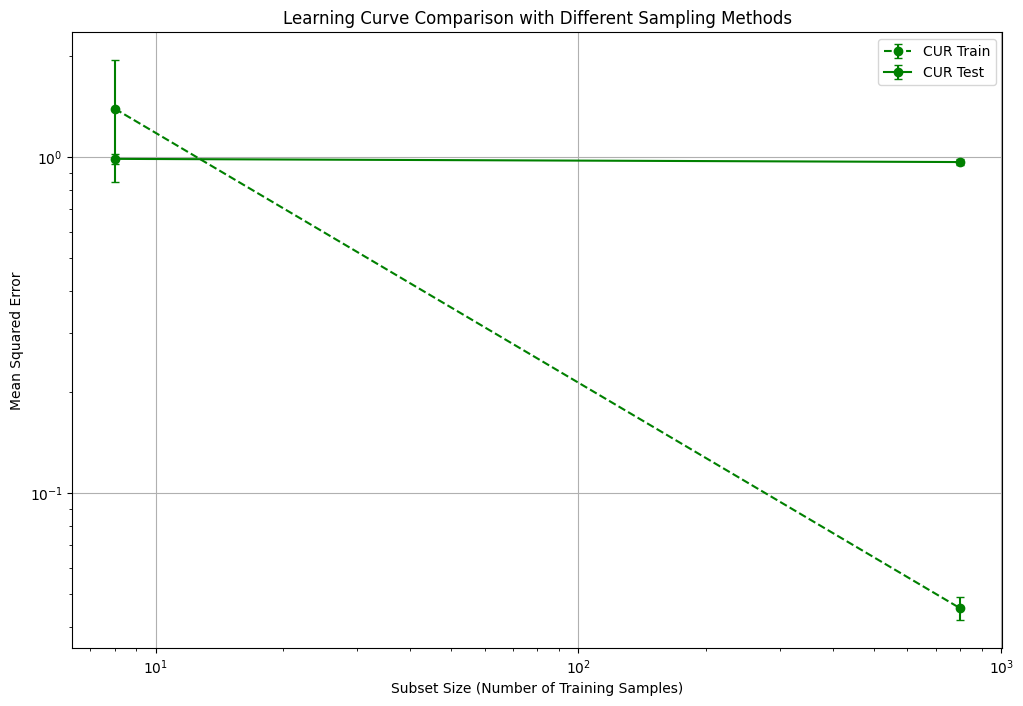

In [20]:
plot_learning_curve_krr_with_samplers(
    X,
    y,
    kernel=rbf_kernel,
    kernel_params={"sigma": 1},
    alpha=1,
    sampling_methods=["CUR"],
    train_sizes=np.logspace(np.log10(0.001), np.log10(0.1), 2)
)